# Dataset analysis 

In [23]:
import numpy as np
import math
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from typing import List, Dict
import seaborn as sns
import json
from matplotlib import cm
from pprint import pformat
import json

import tikzplotlib

from torchvision import transforms
from PIL import Image as Img

from IPython.display import Image 

plt.style.use("seaborn")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [24]:
def load_json(filename : str) -> Dict:
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

In [25]:
base_path_raw = os.path.abspath('/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/')
model_folders = [os.path.join(base_path_raw, o) for o in os.listdir(base_path_raw) if os.path.isdir(os.path.join(base_path_raw,o)) and not o.startswith('.')]

In [26]:
model_folders

['/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/12b1beb780062c34dd2482eb02e705e2',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/309402cd6123961fdd1a827faafdea05',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/edc036f241e350ed66b07d6edebaaef2',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/365ae50c5f1f0a7320a2db9e99cd5cc8',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/f47727dbebdcd1b5f568e0217fcad821',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/0c30cf5d2687230bfb3d20b4e332ab71',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/ab60e3fb01ac94277d5b75f445473d42',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/16ad1271ac0f9f11c79a6d9e2b3cd8a4',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/40a108b1126422e410beedb74aa11453',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/e7c206f34d8805ec23b679297ef284e0',
 '/media/jan/MastatJan/temp/re

In [27]:
folder = model_folders[0]
result = load_json(os.path.join(folder, r'score_dict_final.json'))
exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
result.update({
    'model_base' : exp_dict['model']['base'],
    'context_span' : exp_dict['dataset']['context_span'],
    'loss' : exp_dict['model']['loss']
})

result

{'train_score': 0.9218780815579836,
 'train_weighted_dice': 0.9060430504144016,
 'val_score': 0.7125415387627144,
 'val_weighted_dice': 0.65084917726221,
 'train_loss': 0.005426482817649241,
 'epoch': 15,
 'waiting': 4,
 'test_dice': 0.7045384860494858,
 'test_weighted_dice': 0.6456995348996643,
 'test_iou': 0.5640591275929999,
 'test_prec': 0.6692913673441939,
 'test_recall': 0.7491003927878488,
 'test_score': 0.7045384860494858,
 'model_base': 'unet2d',
 'context_span': 3,
 'loss': 'cross_entropy'}

In [28]:
result = list()
for folder in model_folders:
    r = load_json(os.path.join(folder, r'score_dict_final.json'))
    exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
    r.update({
        'model_base' : exp_dict['model']['base'],
        'context_span' : exp_dict['dataset']['context_span'],
        'loss' : exp_dict['model']['loss'],
        'foldername' : folder.split('/')[-1]
    })
    result.append(r)

result = pd.DataFrame(result).sort_values(['test_weighted_dice', 'test_dice'], ascending = False)
result

,train_score,train_weighted_dice,val_score,val_weighted_dice,train_loss,epoch,waiting,test_dice,test_weighted_dice,test_iou,test_prec,test_recall,test_score,model_base,context_span,loss,foldername,train_dice,val_dice
2,0.961236,0.953535,0.812707,0.773316,0.002601,49.0,0.0,0.801245,0.758672,0.680605,0.750694,0.867133,0.801245,fcn8_vgg16,0,cross_entropy,edc036f241e350ed66b07d6edebaaef2,NaN,NaN
11,0.948136,0.937654,0.796303,0.753627,0.003491,22.0,4.0,0.797494,0.752692,0.677485,0.741776,0.870374,0.797494,fcn8_vgg16,1,cross_entropy,dfaeaf1bd9747b2b0d135fd495f699ec,NaN,NaN
16,0.933321,0.919967,0.799074,0.756370,0.004516,15.0,4.0,0.790756,0.744971,0.668116,0.730645,0.867050,0.790756,fcn8_vgg16,3,cross_entropy,b1292d31b739d2327982349d5f6b27e8,NaN,NaN
3,0.796530,0.796530,0.746038,0.746038,NaN,NaN,NaN,0.781047,0.736184,0.653501,0.881887,0.705622,0.736184,fcn8_vgg16,1,weighted_cross_entropy,365ae50c5f1f0a7320a2db9e99cd5cc8,NaN,NaN
17,0.784901,0.784901,0.739159,0.739159,0.007832,79.0,7.0,0.778928,0.733503,0.650765,0.887492,0.699095,0.733503,fcn8_vgg16,3,weighted_cross_entropy,26aa087080bfa4fb5a6602d6fda8757d,0.778445,0.717757
12,0.920350,0.904357,0.759678,0.707821,0.005402,13.0,4.0,0.768394,0.719089,0.639314,0.728956,0.814906,0.768394,fcn8_resnet,1,cross_entropy,3ce60ea3c13d67ff7334beb1be210603,NaN,NaN
6,0.753727,0.753727,0.712922,0.712922,0.010668,79.0,2.0,0.765031,0.717316,0.633319,0.885921,0.680017,0.717316,fcn8_vgg16,0,weighted_cross_entropy,ab60e3fb01ac94277d5b75f445473d42,0.771991,0.736285
14,0.949649,0.939653,0.746864,0.693197,0.003500,27.0,4.0,0.761630,0.713119,0.631065,0.726637,0.803973,0.761630,unet2d,1,cross_entropy,6ab04a2154becb82b23e49700c9d2396,NaN,NaN
15,0.929930,0.915982,0.750290,0.695581,0.004743,19.0,4.0,0.765448,0.712101,0.640787,0.708914,0.838177,0.765448,fcn8_resnet,3,cross_entropy,4c21df3fe5f18164f1123cbd03edea2b,NaN,NaN
1,0.941394,0.929729,0.768668,0.720168,0.004283,22.0,4.0,0.753172,0.702805,0.620186,0.723951,0.786397,0.753172,unet2d,0,cross_entropy,309402cd6123961fdd1a827faafdea05,NaN,NaN


loss         cross_entropy                      weighted_cross_entropy  \
model_base     fcn8_resnet fcn8_vgg16    unet2d            fcn8_resnet   
context_span                                                             
0                 0.669526   0.758672  0.702805               0.569118   
1                 0.719089   0.752692  0.713119               0.654470   
3                 0.712101   0.744971  0.645700               0.628511   

loss                               
model_base   fcn8_vgg16    unet2d  
context_span                       
0              0.717316  0.630846  
1              0.736184  0.594383  
3              0.733503  0.609810  


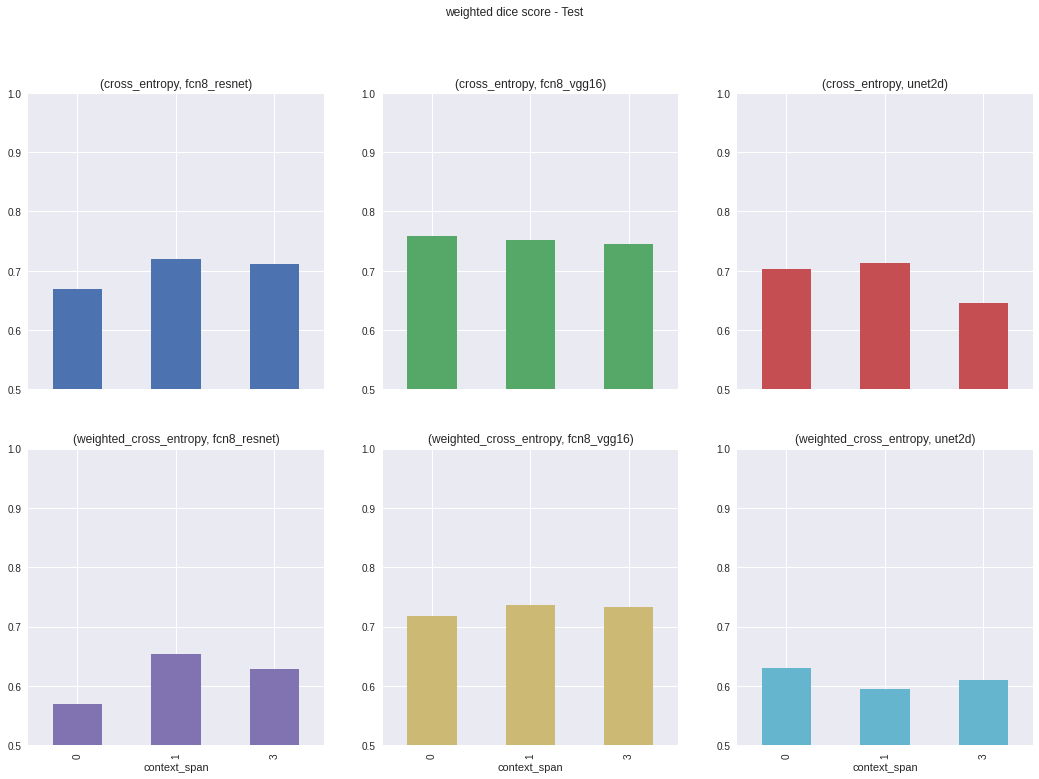

In [29]:
test_wd = result.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_weighted_dice')
test_wd = test_wd.reindex(sorted(test_wd.columns), axis=1)
print(test_wd.head())
test_wd.applymap(lambda x : round(x, 2)).to_html('test_wd.html')
test_wd.plot(kind='bar', subplots = True, layout = (2, 3), legend = False, figsize = (18, 12), ylim = (0.5, 1))
plt.suptitle('weighted dice score - Test')
plt.savefig('test_wd.png')

loss         cross_entropy                      weighted_cross_entropy  \
model_base     fcn8_resnet fcn8_vgg16    unet2d            fcn8_resnet   
context_span                                                             
0                 0.729281   0.801245  0.753172               0.639595   
1                 0.768394   0.797494  0.761630               0.712734   
3                 0.765448   0.790756  0.704538               0.691134   

loss                               
model_base   fcn8_vgg16    unet2d  
context_span                       
0              0.765031  0.693494  
1              0.781047  0.661813  
3              0.778928  0.675766  


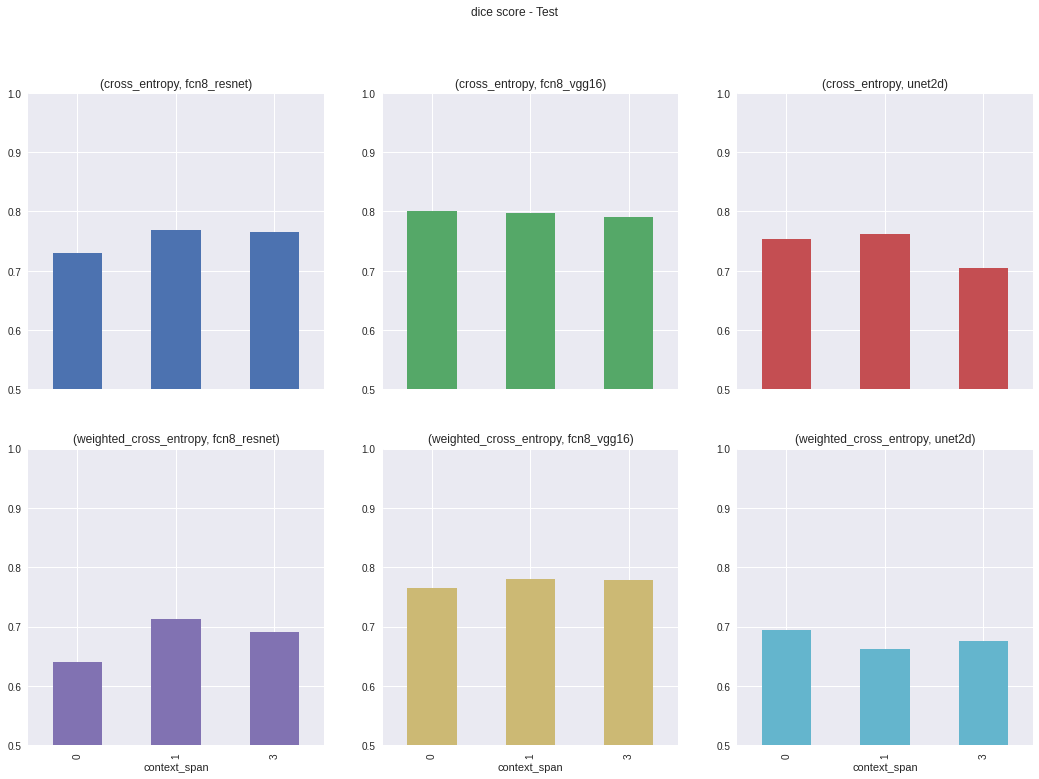

In [30]:
test_d = result.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_dice')
test_d = test_d.reindex(sorted(test_d.columns), axis=1)
print(test_d.head())
test_d.applymap(lambda x : round(x, 2)).to_html('test_d.html')
test_d.plot(kind='bar', subplots = True, layout = (2, 3), legend = False, figsize = (18, 12), ylim = (0.5, 1))
plt.suptitle('dice score - Test')
plt.savefig('test_d.png')

loss         cross_entropy                      weighted_cross_entropy  \
model_base     fcn8_resnet fcn8_vgg16    unet2d            fcn8_resnet   
context_span                                                             
0                 0.919311   0.953535  0.929729               0.667511   
1                 0.904357   0.937654  0.939653               0.710381   
3                 0.915982   0.919967  0.906043               0.674114   

loss                               
model_base   fcn8_vgg16    unet2d  
context_span                       
0              0.753727  0.760412  
1              0.796530  0.701955  
3              0.784901  0.710981  


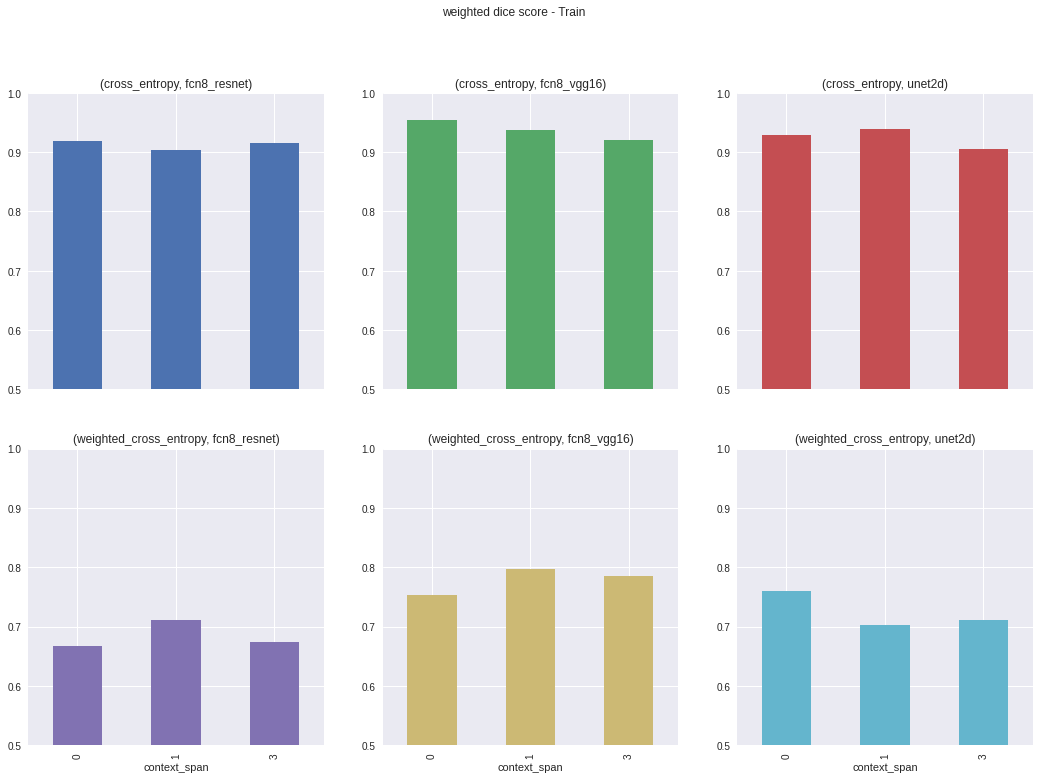

In [31]:
train_wd = result.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'train_weighted_dice')
train_wd = train_wd.reindex(sorted(train_wd.columns), axis=1)
train_wd.applymap(lambda x : round(x, 2)).to_html('train_wd.html')
print(train_wd)
train_wd.plot(kind='bar', subplots = True, layout = (2, 3), legend = False, figsize = (18, 12), ylim = (0.5, 1))
plt.suptitle('weighted dice score - Train')
plt.savefig('train_wd.png')

loss         cross_entropy                      weighted_cross_entropy  \
model_base     fcn8_resnet fcn8_vgg16    unet2d            fcn8_resnet   
context_span                                                             
0                 0.919311   0.953535  0.929729               0.667511   
1                 0.904357   0.937654  0.939653               0.710381   
3                 0.915982   0.919967  0.906043               0.674114   

loss                               
model_base   fcn8_vgg16    unet2d  
context_span                       
0              0.753727  0.760412  
1              0.796530  0.701955  
3              0.784901  0.710981  


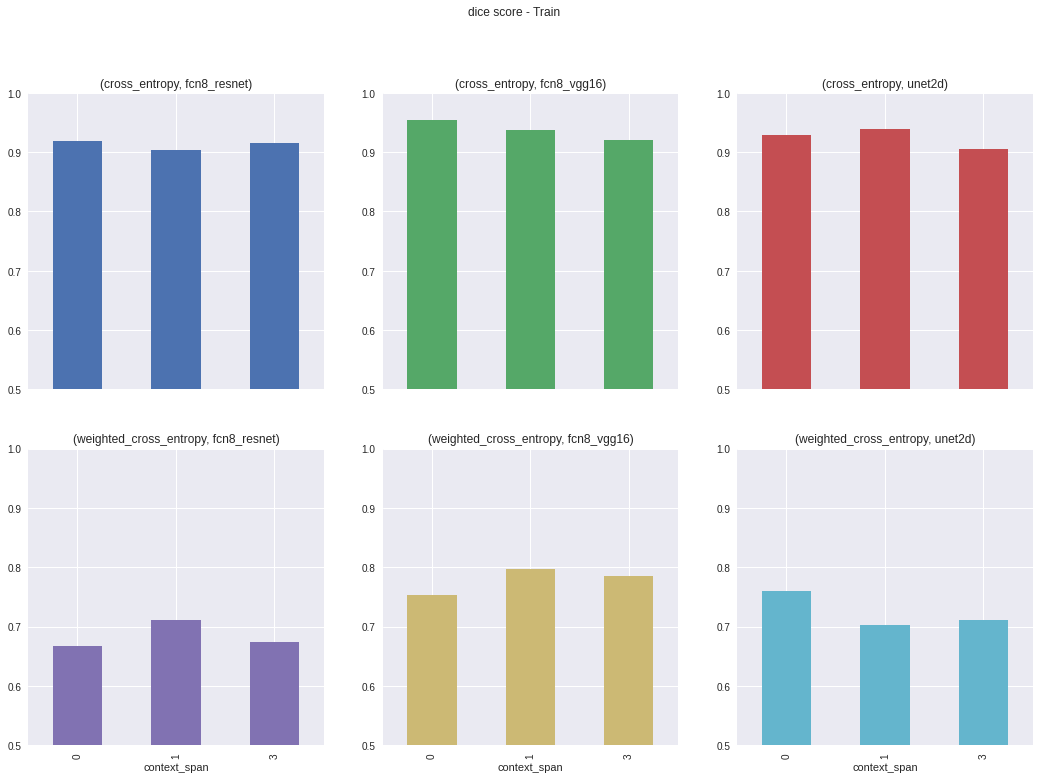

In [32]:
train_d = result.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'train_dice')
train_d = train_wd.reindex(sorted(train_d.columns), axis=1)
train_d.applymap(lambda x : round(x, 2)).to_html('train_d.html')
print(train_d)
train_d.plot(kind='bar', subplots = True, layout = (2, 3), legend = False, figsize = (18, 12), ylim = (0.5, 1))
plt.suptitle('dice score - Train')
plt.savefig('train_d.png')

<AxesSubplot:xlabel='epoch'>

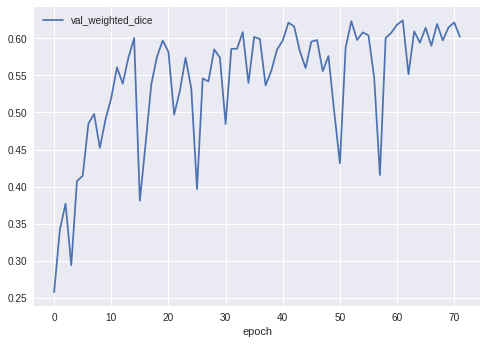

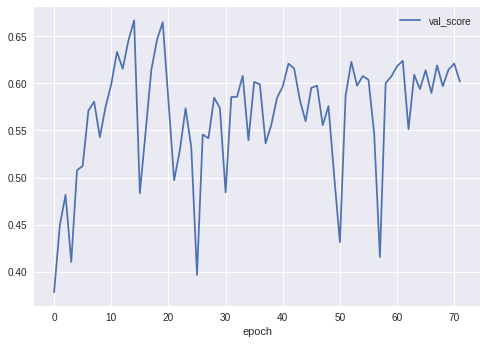

In [33]:
foldername = result.query("context_span == 3 & loss == 'weighted_cross_entropy' & model_base == 'fcn8_resnet'").foldername.iloc[0]
score_df = pd.read_csv(os.path.join(base_path_raw, foldername, 'score_df.csv'), index_col=0)
score_df.plot(x = 'epoch', y = 'val_weighted_dice')
score_df.plot(x = 'epoch', y = 'val_score')

<AxesSubplot:xlabel='epoch'>

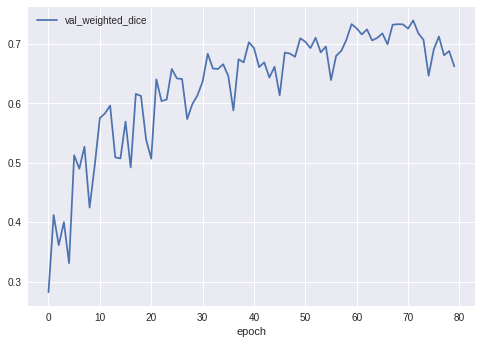

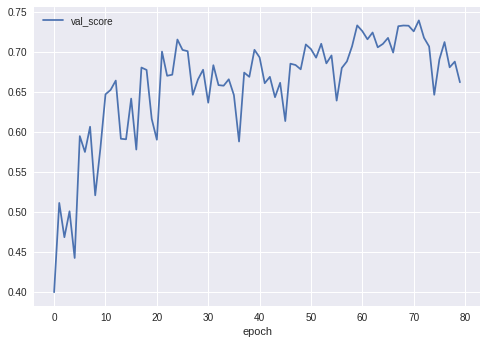

In [34]:
foldername = result.query("context_span == 3 & loss == 'weighted_cross_entropy' & model_base == 'fcn8_vgg16'").foldername.iloc[0]
score_df = pd.read_csv(os.path.join(base_path_raw, foldername, 'score_df.csv'), index_col=0)
score_df.plot(x = 'epoch', y = 'val_weighted_dice')
score_df.plot(x = 'epoch', y = 'val_score')

<AxesSubplot:xlabel='epoch'>

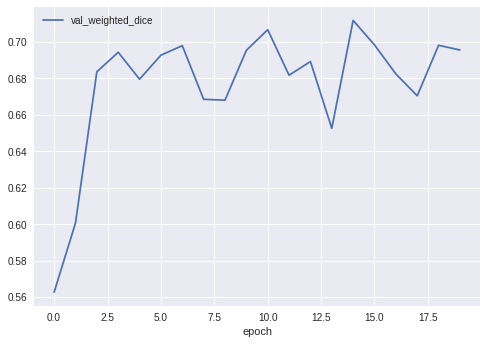

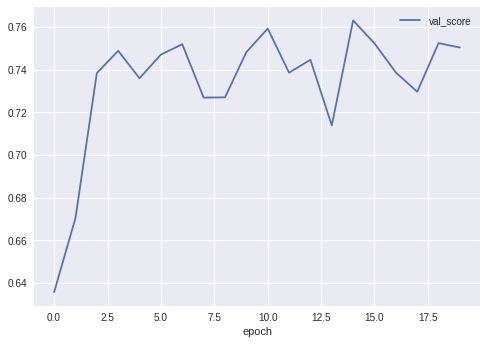

In [35]:
foldername = result.query("context_span == 3 & loss == 'cross_entropy' & model_base == 'fcn8_resnet'").foldername.iloc[0]
score_df = pd.read_csv(os.path.join(base_path_raw, foldername, 'score_df.csv'), index_col=0)
score_df.plot(x = 'epoch', y = 'val_weighted_dice')
score_df.plot(x = 'epoch', y = 'val_score')